# Pumped-Storage Optimisation with Genetic Algorithm and MILP

In [61]:
import pandas as pd
import numpy as np
import plotnine as pn
import plotly.graph_objs as go
import plotly.express as px
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import os
from itertools import product
import datetime
import time

# Import own implementations
from milp import MILP
from genetic_numpy import GA_discrete_actions, evaluate_fitness

background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Price Data

In [62]:
df = pd.read_csv("../01 - Data/spot_prices_utc.csv")
df.head(2)

,spot,utc_time
0,36.99,2017-12-31 23:00:00+00:00
1,31.08,2018-01-01 00:00:00+00:00


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48166 entries, 0 to 48165
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   spot      48166 non-null  float64
 1   utc_time  48166 non-null  object 
dtypes: float64(1), object(1)
memory usage: 752.7+ KB


## The Power Plant

In [64]:
plant_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 5000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 500,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
plant_params["INITIAL_WATER_LEVEL"] = (
    plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
)
plant_params["PUMP_RATE_M3H"] = (
    plant_params["TURBINE_RATE_M3H"] * plant_params["EFFICIENCY"]
)
plant_params["MAX_STORAGE_MWH"] = (
    plant_params["MAX_STORAGE_M3"] / plant_params["TURBINE_RATE_M3H"]
) * plant_params["TURBINE_POWER_MW"]

## Extrapolating MILP Time

- define different lengths (in hours, preferably doubling in size)
- run MILP for a certain amount of randomly determined sequences and log the time needed
- make visualisation using boxplots and extrapolate to periods of full year

In [65]:
runs_per_length = 30
horizon_lengths = [24*x for x in np.arange(1, 7)]
print(horizon_lengths)

np.random.seed(42)
rand_slices = np.random.randint(1, df.shape[0] - np.max(horizon_lengths), size=len(horizon_lengths))

print(rand_slices)

[24, 48, 72, 96, 120, 144]
[15796   861 38159 44733 11285  6266]


In [66]:
hours = []
run = []
run_time = []



for period, rand_slice in tqdm(zip(horizon_lengths, rand_slices)):
    for i in tqdm(range(runs_per_length)):
        start = time.time()
        
        # Select a random subperiod
        prices = df["spot"].iloc[rand_slice : rand_slice + period].values
        times = df["utc_time"].iloc[rand_slice : rand_slice + period].values

        # Solve the model
        milp_solver = MILP(plant_params=plant_params, spot=prices, utc_time=times)
        milp_model, milp_status, milp_profile = milp_solver.solve()

        # Save the results

        run_time.append(time.time() - start)
        hours.append(period)
        run.append(i)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [67]:
plot_data = pd.DataFrame({
    "hours": hours,
    "run": run,
    "run_time": run_time
}).assign(hours = lambda x: x["hours"].astype(str))

plot_data.head()

,hours,run,run_time
0,24,0,0.100198
1,24,1,0.060974
2,24,2,0.083581
3,24,3,0.066817
4,24,4,0.065192


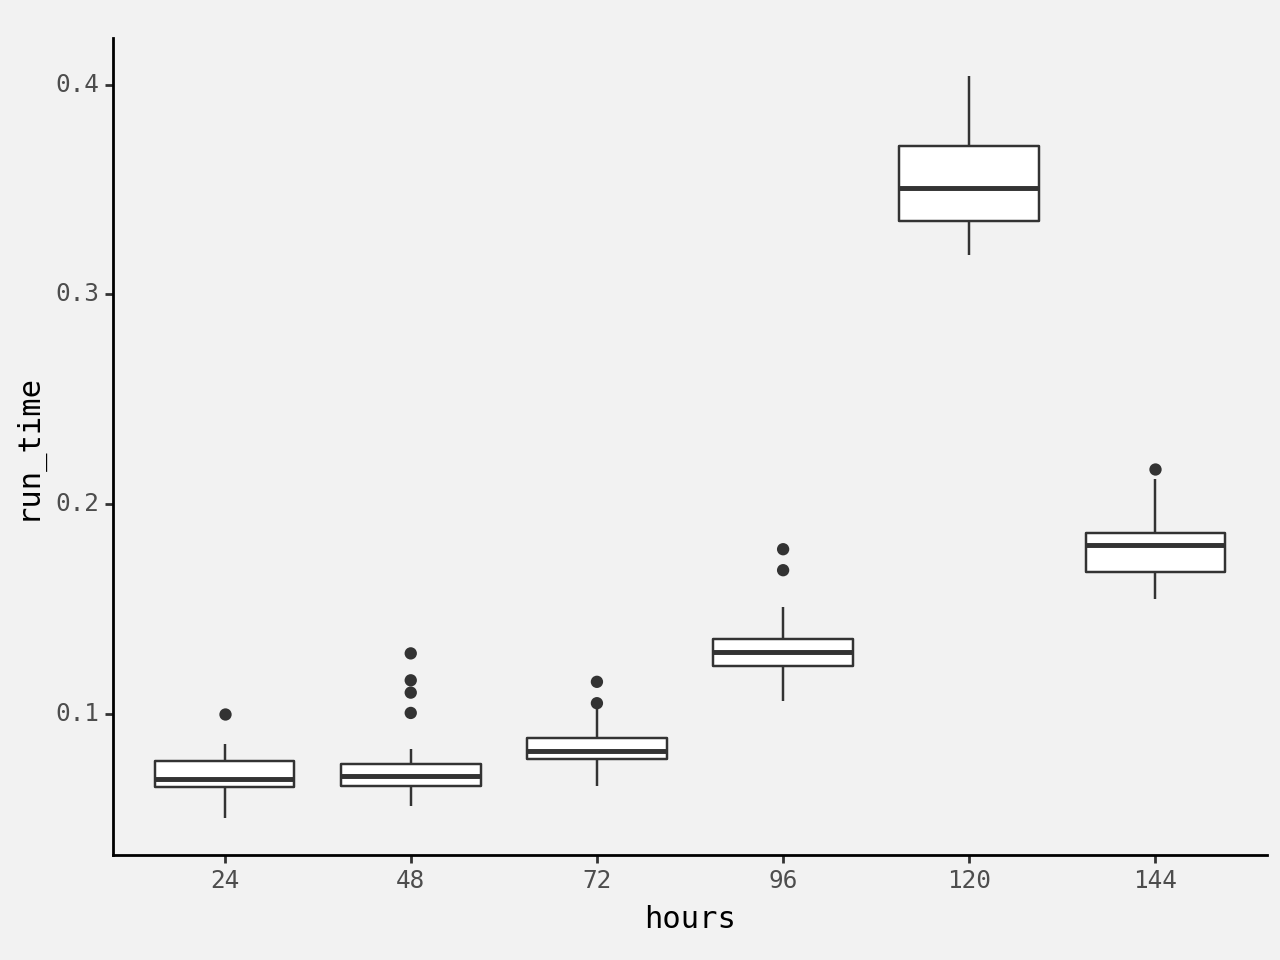

<Figure Size: (640 x 480)>

In [68]:
(
    pn.ggplot(data=plot_data, mapping=pn.aes("hours", "run_time", group="hours"))
    + pn.geom_boxplot()
    + pn.scale_x_discrete(limits=[str(x) for x in horizon_lengths])
)

In [69]:
agg_plot_data = (
    plot_data
    .assign(hours=lambda x: x.hours.astype(np.float32))
    .groupby("hours")
    .agg({"run_time": "mean"})
    .reset_index()
    .assign(delta=lambda x: (x.run_time / x.run_time.shift()) - 1)
)

agg_plot_data

,hours,run_time,delta
0,24.0,0.071352,NaN
1,48.0,0.075556,0.058907
2,72.0,0.083966,0.111318
3,96.0,0.131186,0.562363
4,120.0,0.354609,1.703103
5,144.0,0.180646,-0.490576


### Running the Genetic Algorithm for Different Time Horizons

In [88]:
runs_per_length = 1
horizon_lengths = [24*7*x for x in np.arange(1, 26, 4)]
print(horizon_lengths)

np.random.seed(42)
rand_slices = np.random.randint(1, df.shape[0] - np.max(horizon_lengths), size=len(horizon_lengths))

print(rand_slices)

[168, 840, 1512, 2184, 2856, 3528, 4200]
[15796   861 38159 11285  6266 16851 37195]


In [89]:
hours = []
milp_run_time = []
ga_run_time = []
milp_profits = []
ga_profits = []

for period, rand_slice in tqdm(zip(horizon_lengths, rand_slices)):

    # Select a random subperiod
    prices = df["spot"].iloc[rand_slice : rand_slice + period].values
    times = df["utc_time"].iloc[rand_slice : rand_slice + period].values

    # Solve the MILP model
    start = time.time()
    milp_solver = MILP(plant_params=plant_params, spot=prices, utc_time=times)
    milp_model, milp_status, milp_profile = milp_solver.solve()
    milp_time = time.time() - start

    print(f"MILP: {milp_model.objective.value()}")

    # Run the Genetic algorithm
    start = time.time()
    best_config = {
        "POP_SIZE": 500,
        "INITIAL_MUTATION_RATE": 0.7,
        "FINAL_MUTATION_RATE": 0.15,
        "INITIAL_EXPLORATION": 0.85,
        "ELITISM": 0.9,
        "SURVIVAL_RATE": 0.4,
    }

    ga_solver = GA_discrete_actions(
        plant_params=plant_params,
        spot=prices,
        utc_time=times,
        actions_space=[-1, 0, 1],
    )

    population, fitnesses, history = ga_solver.train(
        config=best_config,
        total_generations=500,
        tune_mode=False,
    )
    ga_time = time.time() - start

    # Get the best individual from the genetic algorithm
    best_individual = [population[np.argmax(fitnesses)]]
    best_fitness = evaluate_fitness(
        prices=prices, population=best_individual, ps_params=plant_params
    )

    milp_run_time.append(milp_time)
    ga_run_time.append(ga_time)
    milp_profits.append(milp_model.objective.value())
    ga_profits.append(best_fitness[0])

0it [00:00, ?it/s]

MILP: 31968.0


  0%|          | 0/500 [00:00<?, ?it/s]

GA: 26244.0
MILP: 161471.0


  0%|          | 0/500 [00:00<?, ?it/s]

GA: -20651.0
MILP: 911104.0


  0%|          | 0/500 [00:00<?, ?it/s]

GA: 444949.0
MILP: 441522.0


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 